## Text EDA and NER implementation on movies related statement

### (Exploratory Analysis + NER algorithm [BiLSTM with glove, BiLSTM with fasttext, BERT uncased])
This notebook provides a walkthrough of text analysis on movies related statements. It includes exploration, visualization and various deep learning based NER algorithm.

### Content
1. **Dataset preparation**
2. **Exploratory Analysis**
3. **NER algorithms**
    * BiLSTM with glove
    * BiLSTM with fasttext
    * CNN + LSTM
    * Multihead inputs (raw text and pos text)
    * BERT uncased

## 1. Dataset preparation
Load necessary libraries and dataset. Perform transformation on dataset for it to be consumed by NER algorithms.
Generate training and validation records up front for further processing.

In [1]:
!pip install -q seqeval

In [2]:
import os
import json
import random
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from string import punctuation as punc
from zipfile import ZipFile
from collections import Counter, OrderedDict
from wordcloud import WordCloud, STOPWORDS

import nltk
from textblob import TextBlob
from nltk import pos_tag
from nltk.util import ngrams
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from seqeval.metrics import f1_score

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras as keras
import tensorflow.keras.backend as K

import fasttext

plt.figure(figsize=(12, 6))
%matplotlib inline

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
def read_file(fname):
    with open(fname, "r") as f:
        lines = f.readlines()

    x, y, unique_y = [[]], [[]], ["pad"]

    for line in lines:
        if line == "\n":
            x.append(list())
            y.append(list())
        else:
            split_y, split_x = line.lower().split("\t")
            x[-1].append(split_x.strip())
            y[-1].append(split_y.strip())
            
            if split_y.strip() not in unique_y:
                unique_y.append(split_y.split()[0])
            

    return x, y, sorted(unique_y)

Read training data and display few records

In [5]:
x_trn, y_trn, categories = read_file("/kaggle/input/crisil/ner_train.txt")

print(f"Sample of training data of NER")
print(x_trn[:2])
print(y_trn[:2])

print(f"\nNumber of X and Y training records {len(x_trn)}, {len(y_trn)}\n")

print(f"Number of unique categories are {len(categories)}")
print(categories)

Sample of training data of NER
[['what', 'movies', 'star', 'bruce', 'willis'], ['show', 'me', 'films', 'with', 'drew', 'barrymore', 'from', 'the', '1980s']]
[['o', 'o', 'o', 'b-actor', 'i-actor'], ['o', 'o', 'o', 'o', 'b-actor', 'i-actor', 'o', 'o', 'b-year']]

Number of X and Y training records 9775, 9775

Number of unique categories are 26
['b-actor', 'b-character', 'b-director', 'b-genre', 'b-plot', 'b-rating', 'b-ratings_average', 'b-review', 'b-song', 'b-title', 'b-trailer', 'b-year', 'i-actor', 'i-character', 'i-director', 'i-genre', 'i-plot', 'i-rating', 'i-ratings_average', 'i-review', 'i-song', 'i-title', 'i-trailer', 'i-year', 'o', 'pad']


Split training records into training and validation records

In [6]:
x_trn, x_val, y_trn, y_val = train_test_split(x_trn, y_trn, test_size=0.20, random_state=42)

print(f"Number of X and Y training records {len(x_trn)}, {len(y_trn)}")
print(f"Number of X and Y validation records {len(x_val)}, {len(y_val)}\n")

print(f"Sample of training data of NER")
print(x_trn[:2])
print(y_trn[:2])

print(f"\nSample of validation data of NER")
print(x_val[:2])
print(y_val[:2])

Number of X and Y training records 7820, 7820
Number of X and Y validation records 1955, 1955

Sample of training data of NER
[['who', 'directed', 'the', 'goonies'], ['who', 'played', 'as', 'agent', 'smith', 'in', 'the', 'matrix']]
[['o', 'o', 'b-title', 'i-title'], ['o', 'o', 'o', 'b-character', 'i-character', 'o', 'b-title', 'i-title']]

Sample of validation data of NER
[['who', 'directed', 'laputa', 'castle', 'in', 'the', 'sky'], ['are', 'there', 'any', 'movies', 'about', 'the', 'navy', 'from', 'the', 'last', 'ten', 'years', 'that', 'are', 'rated', 'pg', '13']]
[['o', 'o', 'b-title', 'i-title', 'i-title', 'i-title', 'i-title'], ['o', 'o', 'o', 'o', 'o', 'o', 'b-plot', 'o', 'o', 'b-year', 'i-year', 'i-year', 'o', 'o', 'o', 'b-rating', 'i-rating']]


Read testing data and display few records

In [7]:
x_test, y_test, _ = read_file("/kaggle/input/crisil/ner_test.txt")

print(f"Sample of testing data of NER")
print(x_test[:2])
print(y_test[:2])

print(f"\nNumber of X and Y testing records {len(x_test)}, {len(y_test)}")

Sample of testing data of NER
[['are', 'there', 'any', 'good', 'romantic', 'comedies', 'out', 'right', 'now'], ['show', 'me', 'a', 'movie', 'about', 'cars', 'that', 'talk']]
[['o', 'o', 'o', 'o', 'b-genre', 'i-genre', 'o', 'b-year', 'i-year'], ['o', 'o', 'o', 'o', 'o', 'b-plot', 'i-plot', 'i-plot']]

Number of X and Y testing records 2443, 2443


We have not performed any kind of string cleaning as our mapping would have distrub in that situation. We are assuming words present in our records are present inside glove corpus. In case fasttext, bert we are using sub word and word piece tokenization so assuming they will handle this situation much better if word is not present.

## 2. Exploratory Analysis
The available data contains only two records input text and relevent output text. In this section we will create some additional features using available records. Following list explains different ideas for creating new features.

#### 2.1 Statistical Count Features from text
* **Word Count** - Total number of words
* **Character Count** - Total number of characters excluding spaces
* **Word Density** - Average length of the words
* **Punctuation Count** - Total number of punctuations

#### 2.2 Text Features
* **Sentiment: Polarity** - sentiment value computed using textblob package
* **Part of Speech** - Nouns to Verbs Ratio - ratio of nouns and verbs used in the text

#### 2.3 Bag of Words analysis
* **Top Word Usage** - sentiment value computed using textblob package
* **N-grams Analysis** - Nouns to Verbs Ratio - ratio of nouns and verbs used in the text

Generate dataframe for analysis

In [8]:
df_trn = pd.DataFrame({"text_in": [' '.join([word for word in sent]) for sent in x_trn], "text_out": [' '.join([word for word in sent]) for sent in y_trn], "x": x_trn, 
                       "y": y_trn})
df_val = pd.DataFrame({"text_in": [' '.join([word for word in sent]) for sent in x_val], "text_out": [' '.join([word for word in sent]) for sent in y_val], "x": x_val, 
                       "y": y_val})
df_test = pd.DataFrame({"text_in": [' '.join([word for word in sent]) for sent in x_test], "text_out": [' '.join([word for word in sent]) for sent in y_test], 
                        "x": x_test, "y": y_test})

In [9]:
df_trn.head()

,text_in,text_out,x,y
0,who directed the goonies,o o b-title i-title,"[who, directed, the, goonies]","[o, o, b-title, i-title]"
1,who played as agent smith in the matrix,o o o b-character i-character o b-title i-title,"[who, played, as, agent, smith, in, the, matrix]","[o, o, o, b-character, i-character, o, b-title..."
2,find me movies since 2002 about a dog,o o o b-year i-year o o b-plot,"[find, me, movies, since, 2002, about, a, dog]","[o, o, o, b-year, i-year, o, o, b-plot]"
3,in 1990 what action films were really good,o b-year o b-genre o o b-ratings_average i-rat...,"[in, 1990, what, action, films, were, really, ...","[o, b-year, o, b-genre, o, o, b-ratings_averag..."
4,movie directed by charles hood that received w...,o o o b-director i-director o b-ratings_averag...,"[movie, directed, by, charles, hood, that, rec...","[o, o, o, b-director, i-director, o, b-ratings..."


In [10]:
df_val.head()

,text_in,text_out,x,y
0,who directed laputa castle in the sky,o o b-title i-title i-title i-title i-title,"[who, directed, laputa, castle, in, the, sky]","[o, o, b-title, i-title, i-title, i-title, i-t..."
1,are there any movies about the navy from the l...,o o o o o o b-plot o o b-year i-year i-year o ...,"[are, there, any, movies, about, the, navy, fr...","[o, o, o, o, o, o, b-plot, o, o, b-year, i-yea..."
2,what is the movie a wonderful world,o o o o o b-title i-title,"[what, is, the, movie, a, wonderful, world]","[o, o, o, o, o, b-title, i-title]"
3,what year was blazing saddles released,o o o b-title i-title o,"[what, year, was, blazing, saddles, released]","[o, o, o, b-title, i-title, o]"
4,when will the dark knight rises release a new ...,o o b-title i-title i-title i-title o o o b-tr...,"[when, will, the, dark, knight, rises, release...","[o, o, b-title, i-title, i-title, i-title, o, ..."


In [11]:
df_test.head()

,text_in,text_out,x,y
0,are there any good romantic comedies out right...,o o o o b-genre i-genre o b-year i-year,"[are, there, any, good, romantic, comedies, ou...","[o, o, o, o, b-genre, i-genre, o, b-year, i-year]"
1,show me a movie about cars that talk,o o o o o b-plot i-plot i-plot,"[show, me, a, movie, about, cars, that, talk]","[o, o, o, o, o, b-plot, i-plot, i-plot]"
2,list the five star rated movies starring mel g...,o o b-ratings_average i-ratings_average o o o ...,"[list, the, five, star, rated, movies, starrin...","[o, o, b-ratings_average, i-ratings_average, o..."
3,what science fiction films have come out recently,o b-genre i-genre o o o o b-year,"[what, science, fiction, films, have, come, ou...","[o, b-genre, i-genre, o, o, o, o, b-year]"
4,did the same director make all of the harry po...,o o o o o o o o b-title i-title o,"[did, the, same, director, make, all, of, the,...","[o, o, o, o, o, o, o, o, b-title, i-title, o]"


#### 2.1 Statistical Count Features from text

In [12]:
df_trn["word_count"] = df_trn["text_in"].apply(lambda x : len(x.split()))
df_trn["char_count"] = df_trn["text_in"].apply(lambda x : len(x.replace(" ", "")))
df_trn["word_density"] = df_trn["word_count"] / (df_trn["char_count"] + 1)
df_trn["punc_count"] = df_trn["text_in"].apply(lambda x : len([a for a in x if a in punc]))

df_trn[["word_count", "char_count", "word_density", "punc_count"]].head(10)

,word_count,char_count,word_density,punc_count
0,4,21,0.181818,0
1,8,32,0.242424,0
2,8,30,0.258065,0
3,8,35,0.222222,0
4,24,104,0.228571,0
5,10,42,0.232558,0
6,10,46,0.212766,0
7,11,59,0.183333,0
8,8,34,0.228571,0
9,5,19,0.250000,0


In [13]:
df_val["word_count"] = df_val["text_in"].apply(lambda x : len(x.split()))
df_val["char_count"] = df_val["text_in"].apply(lambda x : len(x.replace(" ", "")))
df_val["word_density"] = df_val["word_count"] / (df_val["char_count"] + 1)
df_val["punc_count"] = df_val["text_in"].apply(lambda x : len([a for a in x if a in punc]))

df_val[["word_count", "char_count", "word_density", "punc_count"]].head(10)

,word_count,char_count,word_density,punc_count
0,7,31,0.218750,0
1,17,64,0.261538,0
2,7,29,0.233333,0
3,6,33,0.176471,0
4,10,44,0.222222,0
5,11,42,0.255814,0
6,8,36,0.216216,0
7,12,68,0.173913,0
8,11,49,0.220000,0
9,13,56,0.228070,0


In [14]:
df_test["word_count"] = df_test["text_in"].apply(lambda x : len(x.split()))
df_test["char_count"] = df_test["text_in"].apply(lambda x : len(x.replace(" ", "")))
df_test["word_density"] = df_test["word_count"] / (df_test["char_count"] + 1)
df_test["punc_count"] = df_test["text_in"].apply(lambda x : len([a for a in x if a in punc]))

df_test[["word_count", "char_count", "word_density", "punc_count"]].head(10)

,word_count,char_count,word_density,punc_count
0,9,42,0.209302,0
1,8,29,0.266667,0
2,9,43,0.204545,0
3,8,42,0.186047,0
4,11,47,0.229167,0
5,5,23,0.208333,0
6,13,47,0.270833,0
7,10,41,0.238095,0
8,7,35,0.194444,0
9,9,42,0.209302,0


In [15]:
# Max length of input text in training, validation and test df
maxlen_trn = df_trn["word_count"].max()
maxlen_val = df_val["word_count"].max()
maxlen_test = df_test["word_count"].max()

print(f"Maximum sentences length in training records is {maxlen_trn}")
print(f"Maximum sentences length in validation records is {maxlen_val}")
print(f"Maximum sentences length in testing records is {maxlen_test}")

Maximum sentences length in training records is 47
Maximum sentences length in validation records is 31
Maximum sentences length in testing records is 38


In [16]:
# Find maximum value of sentence from training, validation and test records for deciding maxlen
maxlen = max([maxlen_trn, maxlen_val, maxlen_test])
print(f"Maximum sentences length should be consider is {maxlen}")

Maximum sentences length should be consider is 47


#### 2.2 Generate Text Features - Sentiment Polarity & Part of Speech

In [17]:
# function to obtain the sentiment using textblob package
def get_polarity(text):
    pol = TextBlob(text).sentiment.polarity

    return pol

# function to obtain the part of speech using textblob package
def get_pos(text):
    pos = [tag[1] for tag in TextBlob(text).tags]

    return pos

In [18]:
df_trn["polarity"] = df_trn["text_in"].apply(get_polarity)
df_trn["pos"] = df_trn["text_in"].apply(get_pos)
df_trn[["text_in", "polarity", "pos"]].head()

,text_in,polarity,pos
0,who directed the goonies,0.0,"[WP, VBD, DT, NNS]"
1,who played as agent smith in the matrix,0.0,"[WP, VBD, IN, NN, NN, IN, DT, NN]"
2,find me movies since 2002 about a dog,0.0,"[VB, PRP, NNS, IN, CD, IN, DT, NN]"
3,in 1990 what action films were really good,0.4,"[IN, CD, WP, NN, NNS, VBD, RB, JJ]"
4,movie directed by charles hood that received w...,0.0,"[NN, VBN, IN, NNS, NN, IN, VBD, RB, NNS, WDT, ..."


In [19]:
df_val["polarity"] = df_val["text_in"].apply(get_polarity)
df_val["pos"] = df_val["text_in"].apply(get_pos)
df_val[["text_in", "polarity", "pos"]].head()

,text_in,polarity,pos
0,who directed laputa castle in the sky,0.000000,"[WP, VBD, JJ, NN, IN, DT, NN]"
1,are there any movies about the navy from the l...,0.000000,"[VBP, EX, DT, NNS, IN, DT, NN, IN, DT, JJ, JJ,..."
2,what is the movie a wonderful world,1.000000,"[WP, VBZ, DT, NN, DT, JJ, NN]"
3,what year was blazing saddles released,0.000000,"[WP, NN, VBD, VBG, NNS, VBN]"
4,when will the dark knight rises release a new ...,-0.006818,"[WRB, MD, DT, JJ, NN, VBZ, VB, DT, JJ, NN]"


In [20]:
df_test["polarity"] = df_test["text_in"].apply(get_polarity)
df_test["pos"] = df_test["text_in"].apply(get_pos)
df_test[["text_in", "polarity", "pos"]].head()

,text_in,polarity,pos
0,are there any good romantic comedies out right...,0.328571,"[VBP, RB, DT, JJ, JJ, NNS, RP, RB, RB]"
1,show me a movie about cars that talk,0.000000,"[VB, PRP, DT, NN, IN, NNS, WDT, VBP]"
2,list the five star rated movies starring mel g...,0.000000,"[NN, DT, CD, NN, VBN, NNS, VBG, NN, NN]"
3,what science fiction films have come out recently,0.000000,"[WP, NN, NN, NNS, VBP, VBN, RP, RB]"
4,did the same director make all of the harry po...,0.000000,"[VBD, DT, JJ, NN, VBP, DT, IN, DT, NN, NN, NNS]"


We can use this pos tags as input or output to the model to improve performs. In case of pos as input it will be treated as multi head input model & pos as output it will be treated as multi head output model.

#### 2.3 Bag of Words analysis - Top words usage, N-grams analysis

* Top Words Used
* N-gram Analysis
* Word Cloud
* Class distribution

### Top Words Used

In [21]:
# Set english stop words
stop_words = set(stopwords.words("english"))

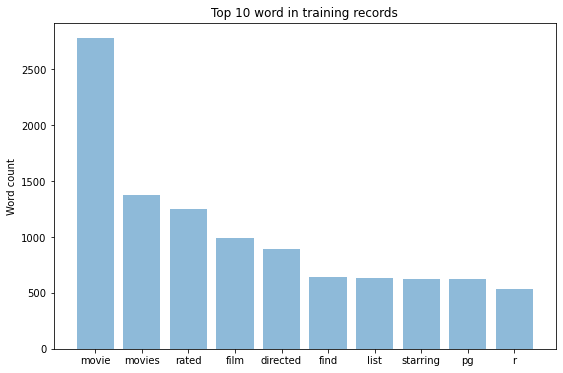

In [22]:
trn_word_count = Counter([word for sent in x_trn for word in sent if word not in stop_words])
trn_word_count_freq = trn_word_count.most_common(10)

plt.figure(figsize=(9, 6))
plt.bar([pair[0] for pair in trn_word_count_freq], [pair[1] for pair in trn_word_count_freq], align="center", alpha=0.5)
plt.ylabel("Word count")
plt.title("Top 10 word in training records")
plt.show()

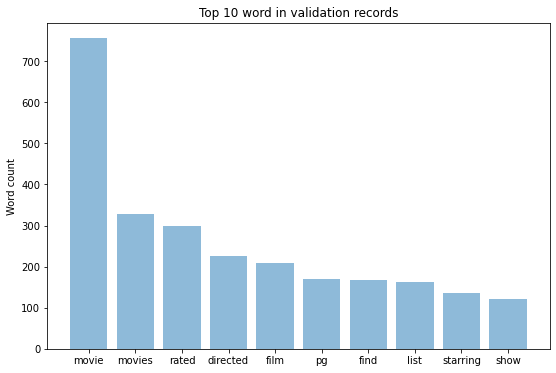

In [23]:
val_word_count = Counter([word for sent in x_val for word in sent if word not in stop_words])
val_word_count_freq = val_word_count.most_common(10)

plt.figure(figsize=(9, 6))
plt.bar([pair[0] for pair in val_word_count_freq], [pair[1] for pair in val_word_count_freq], align="center", alpha=0.5)
plt.ylabel("Word count")
plt.title("Top 10 word in validation records")
plt.show()

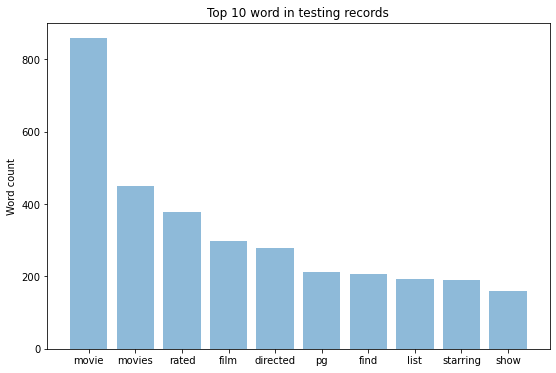

In [24]:
test_word_count = Counter([word for sent in x_test for word in sent if word not in stop_words])
test_word_count_freq = test_word_count.most_common(10)

plt.figure(figsize=(9, 6))
plt.bar([pair[0] for pair in test_word_count_freq], [pair[1] for pair in test_word_count_freq], align="center", alpha=0.5)
plt.ylabel("Word count")
plt.title("Top 10 word in testing records")
plt.show()

### N-gram Analysis (BiGram)

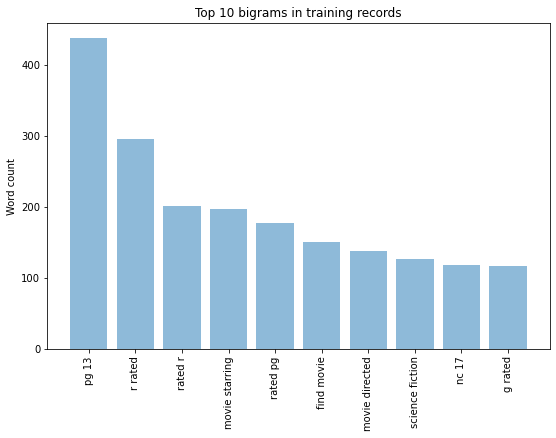

In [25]:
trn_ngrams = Counter(ngrams([word for sent in x_trn for word in sent if word not in stop_words], 2))
trn_ngrams_freq = trn_ngrams.most_common(10)

plt.figure(figsize=(9, 6))
plt.bar([str(' '.join([w for w in pair[0]])) for pair in trn_ngrams_freq], [pair[1] for pair in trn_ngrams_freq], align="center", alpha=0.5)
plt.xticks(rotation='vertical')
plt.ylabel("Word count")
plt.title("Top 10 bigrams in training records")
plt.show()

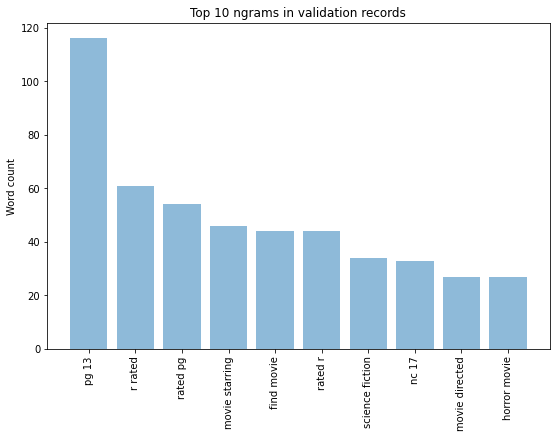

In [26]:
val_ngrams = Counter(ngrams([word for sent in x_val for word in sent if word not in stop_words], 2))
val_ngrams_freq = val_ngrams.most_common(10)

plt.figure(figsize=(9, 6))
plt.bar([str(' '.join([w for w in pair[0]])) for pair in val_ngrams_freq], [pair[1] for pair in val_ngrams_freq], align="center", alpha=0.5)
plt.xticks(rotation='vertical')
plt.ylabel("Word count")
plt.title("Top 10 ngrams in validation records")
plt.show()

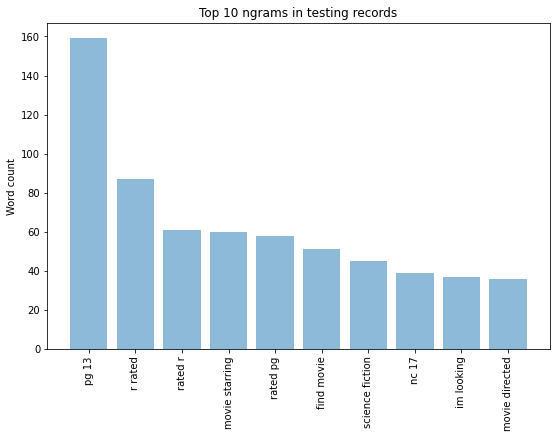

In [27]:
test_ngrams = Counter(ngrams([word for sent in x_test for word in sent if word not in stop_words], 2))
test_ngrams_freq = test_ngrams.most_common(10)

plt.figure(figsize=(9, 6))
plt.bar([str(' '.join([w for w in pair[0]])) for pair in test_ngrams_freq], [pair[1] for pair in test_ngrams_freq], align="center", alpha=0.5)
plt.xticks(rotation='vertical')
plt.ylabel("Word count")
plt.title("Top 10 ngrams in testing records")
plt.show()

Performing stemming or lemmatization will help us to get good accuracy as you can see movie and movies words are separately treated in our records while training

### Word Cloud

In [28]:
# Build word cloud
def create_cloud(string, title=None):
    cloud = WordCloud(height=1080, 
                      width=1920, 
                      background_color='white', 
                      min_font_size=10, 
                      stopwords=STOPWORDS).generate(string)
    plt.figure(figsize=(15,30))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    if title:
        plt.title(title, fontdict={'fontsize':24})
    plt.show()

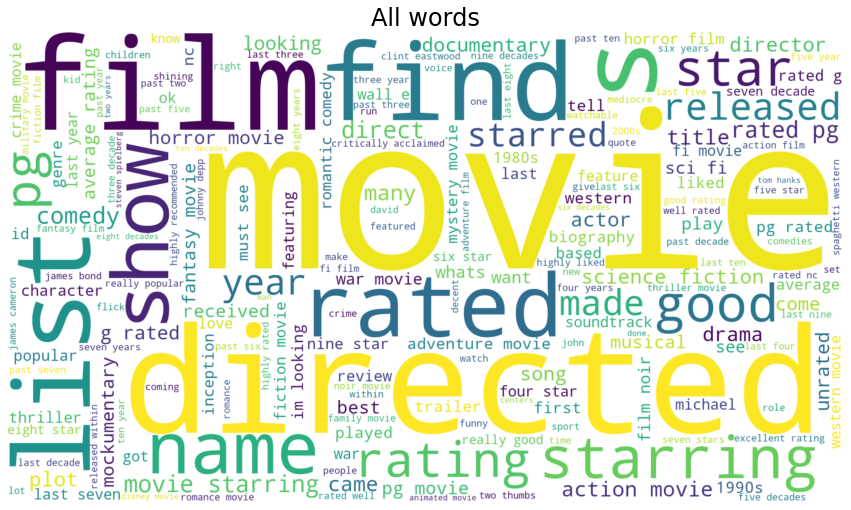

In [29]:
# Training data word cloud
create_cloud(' '.join(word for sent in x_trn for word in sent), "All words") 

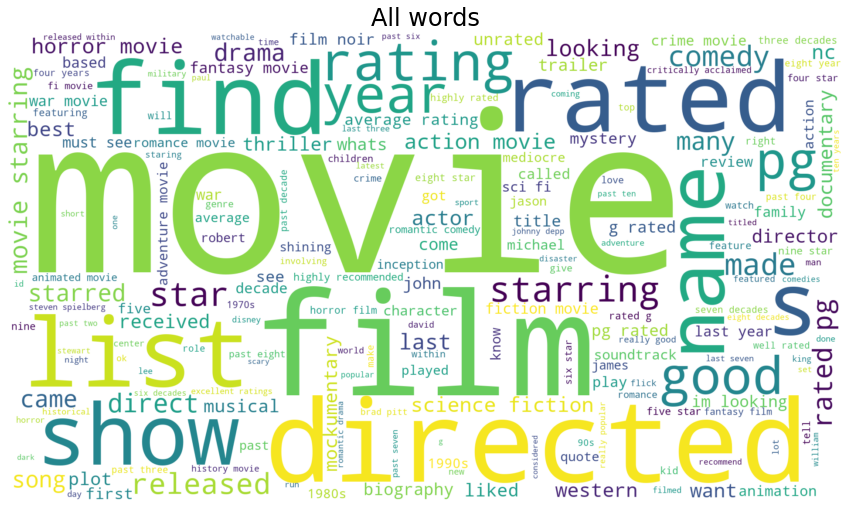

In [30]:
# Validation data word cloud
create_cloud(' '.join(word for sent in x_val for word in sent), "All words") 

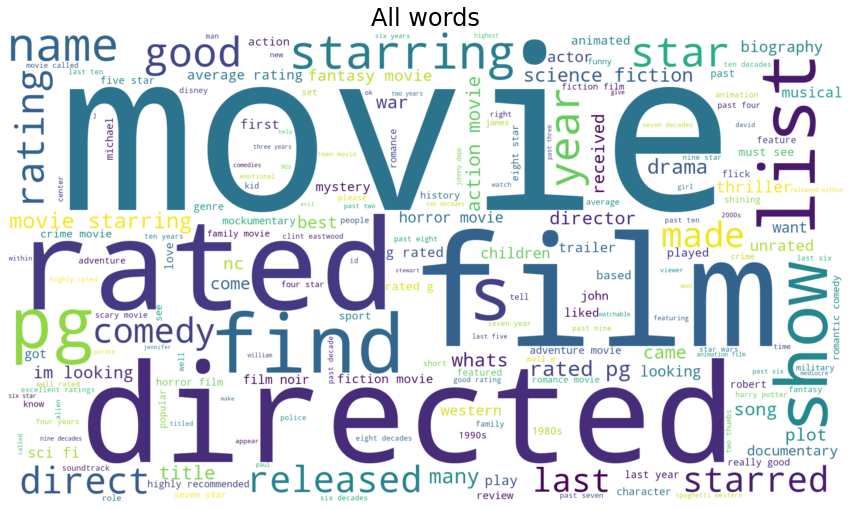

In [31]:
# Testing data word cloud
create_cloud(' '.join(word for sent in x_test for word in sent), "All words") 

### Class distribution

In [32]:
def func(y):
    counts = Counter([label for sent_output in y for label in sent_output])
    # Setting 'o' label to zero for better visibility of labels counter
    counts['o'] = 0
    return counts.keys(), counts.values()

<BarContainer object of 25 artists>

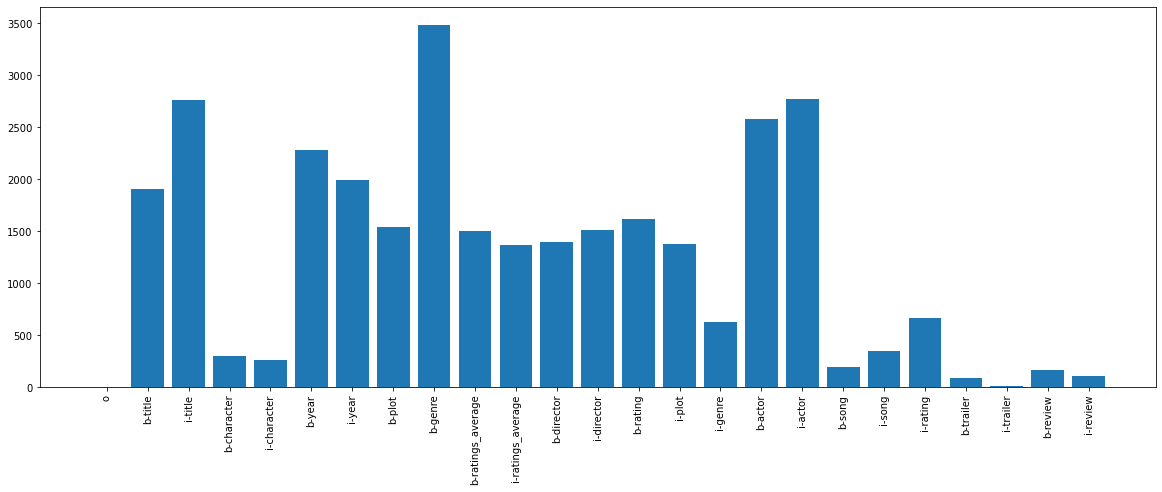

In [33]:
y_trn_keys, y_trn_values = func(y_trn)

plt.figure(figsize=(20,7))
plt.xticks(rotation=90)
plt.bar(y_trn_keys, y_trn_values)

<BarContainer object of 25 artists>

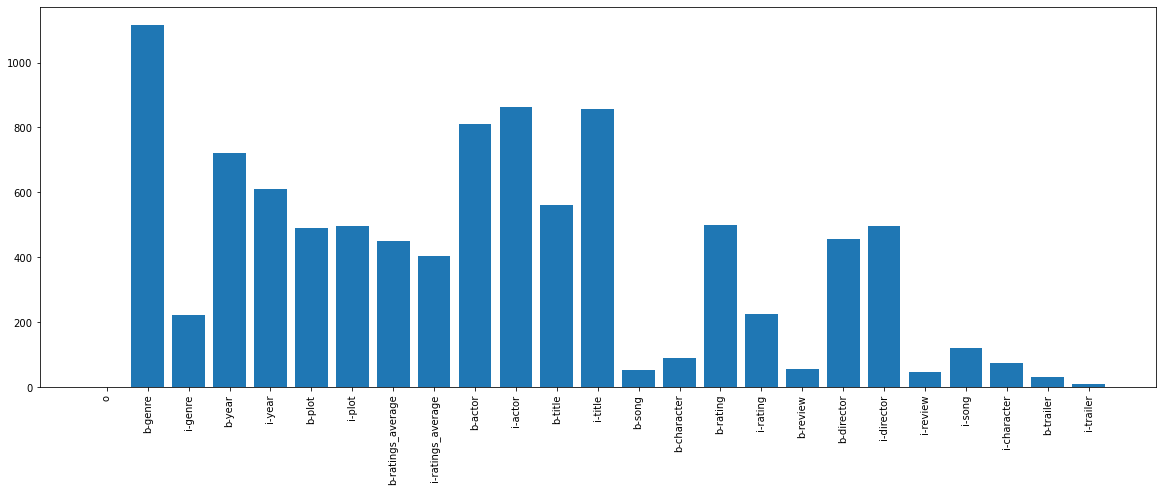

In [34]:
y_test_keys, y_test_values = func(y_test)

plt.figure(figsize=(20,7))
plt.xticks(rotation=90)
plt.bar(y_test_keys, y_test_values)

<BarContainer object of 25 artists>

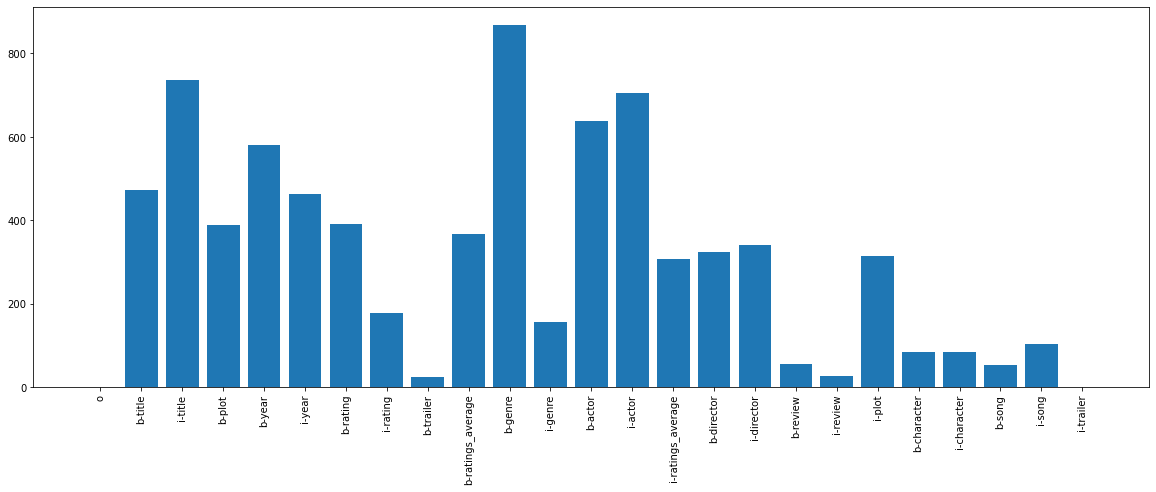

In [35]:
y_val_keys, y_val_values = func(y_val)

plt.figure(figsize=(20,7))
plt.xticks(rotation=90)
plt.bar(y_val_keys, y_val_values)

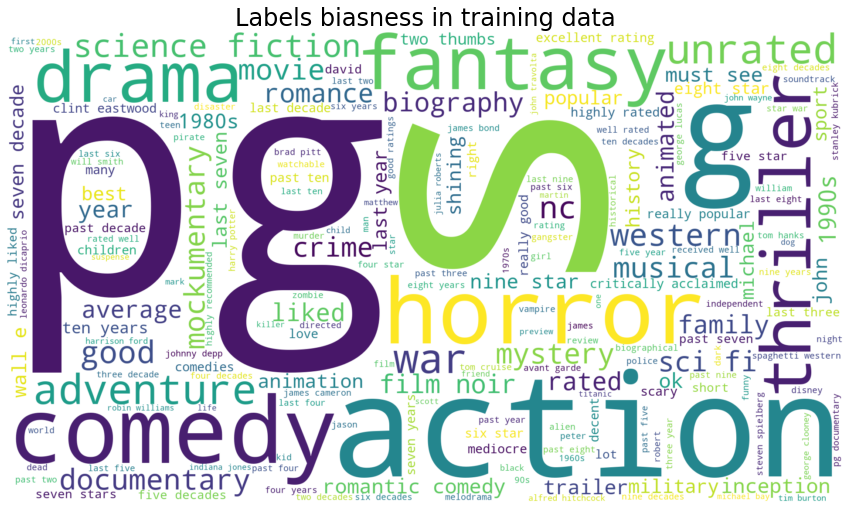

In [36]:
# Check if there is label biasness present in training data
create_cloud(' '.join([word if label != 'o' else '' for sent_in, sent_out in zip(x_trn, y_trn) for word, label in zip(sent_in, sent_out)]), 
             "Labels biasness in training data")

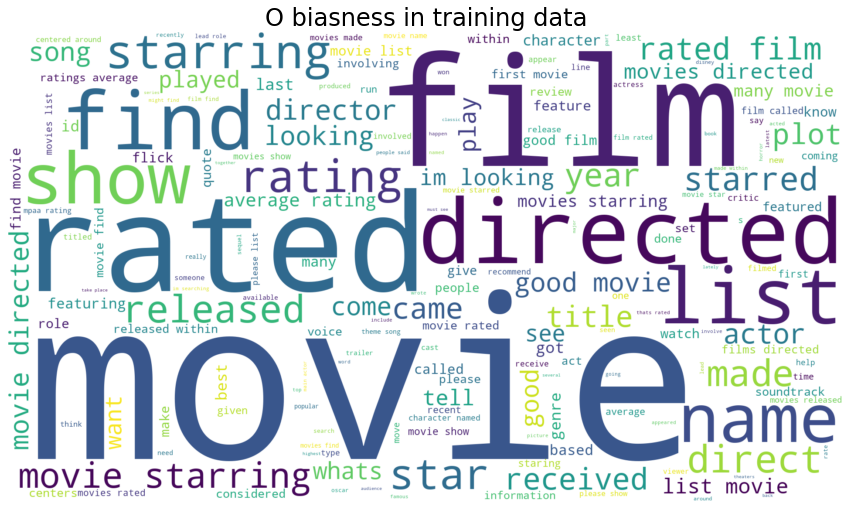

In [37]:
create_cloud(' '.join([word if label == 'o' else '' for sent_in, sent_out in zip(x_trn, y_trn) for word, label in zip(sent_in, sent_out)]), 
             "O biasness in training data")

### Utils

In [38]:
def get_file(fname, url):
    fpath = os.path.join(os.getcwd(), fname)
    fdownloaded = False
    funzipped = False

    if not os.path.exists(fpath):
        try:
            print(f"Downloading {fname}...")
            response = requests.get(url, stream=True)

            total_size_in_bytes= int(response.headers.get("content-length", 0))
            block_size = 1024
            progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)

            with open(fpath, "wb") as f:
                for data in response.iter_content(block_size):
                    progress_bar.update(len(data))
                    f.write(data)
            
            if fname.endswith(".zip"):
                print(f"Extracting {fname}...")
                with ZipFile(fpath, "r") as f:
                    for file in tqdm(iterable=f.namelist(), total=len(f.namelist())):
                        f.extract(member=file)

        except Exception as e:
            print(f"Error in downloading or unzipping file check below error.\n {e}")

    return fpath, fdownloaded, funzipped

In [39]:
glove_fpath, glove_fdownloaded, glove_funzipped = get_file("glove.6B.zip", "http://nlp.stanford.edu/data/glove.6B.zip")

100%|█████████▉| 861M/862M [02:42<00:00, 4.39MiB/s]
  0%|          | 0/4 [00:00<?, ?it/s]

Extracting glove.6B.zip...



 50%|█████     | 2/4 [00:04<00:04,  2.20s/it]
100%|██████████| 862M/862M [03:00<00:00, 4.39MiB/s]
100%|██████████| 4/4 [00:18<00:00,  4.67s/it]


In [40]:
# Quantized version of fasttext english word embeddings from 300 to 100 dimension
fasttext_fpath, fasttext_fdownloaded, fasttext_funzipped = get_file("cc.en.100.bin", 
                                                                "https://geniekalp.s3.ap-south-1.amazonaws.com/pretrained_embeddings/cc.en.100.bin")


  0%|          | 0.00/2.44G [00:00<?, ?iB/s]
  0%|          | 2.05k/2.44G [00:00<33:14:19, 20.4kiB/s]
  0%|          | 36.9k/2.44G [00:00<3:15:07, 208kiB/s]  
  0%|          | 71.7k/2.44G [00:00<2:32:16, 267kiB/s]
  0%|          | 194k/2.44G [00:00<1:04:50, 626kiB/s] 
  0%|          | 402k/2.44G [00:00<36:00, 1.13MiB/s] 
  0%|          | 820k/2.44G [00:00<19:11, 2.11MiB/s]
  0%|          | 1.69M/2.44G [00:00<09:44, 4.17MiB/s]
  0%|          | 3.19M/2.44G [00:00<05:26, 7.44MiB/s]
  0%|          | 5.12M/2.44G [00:00<03:42, 10.9MiB/s]
  0%|          | 6.81M/2.44G [00:01<03:13, 12.6MiB/s]
  0%|          | 8.83M/2.44G [00:01<02:45, 14.7MiB/s]
  0%|          | 10.4M/2.44G [00:01<02:42, 15.0MiB/s]
  1%|          | 12.4M/2.44G [00:01<02:29, 16.2MiB/s]
  1%|          | 14.2M/2.44G [00:01<02:27, 16.5MiB/s]
  1%|          | 16.1M/2.44G [00:01<02:23, 16.8MiB/s]
  1%|          | 17.9M/2.44G [00:01<02:20, 17.2MiB/s]
  1%|          | 19.7M/2.44G [00:01<02:19, 17.3MiB/s]
  1%|          | 21.6M/2.44G 

In [41]:
# Load glove embedding which provides us embedding matrix and its word to id mapping and vice versa
def load_glove(fpath, dim):
    with open(fpath, "r") as f:
        lines = f.readlines()

    matrix = np.zeros((len(lines), dim))
    id2word = dict()
    word2id = dict()

    for idx, line in enumerate(lines):
        line_split = line.split()
        word = line_split[0]

        matrix[idx] = line_split[1:]

        id2word[idx] = word
        word2id[word] = idx

    return matrix, id2word, word2id

glove_matrix, glove_id2word, glove_word2id = load_glove("glove.6B.100d.txt", 100)

print(f"Shape of matrix is {glove_matrix.shape}\n")
print(f"Cross checking word2id and id2word contains same number of records. word2id are {len(glove_word2id.keys())} and \
id2word are {len(glove_id2word.keys())}")


100%|██████████| 2.44G/2.44G [02:07<00:00, 18.0MiB/s]

Shape of matrix is (400000, 100)

Cross checking word2id and id2word contains same number of records. word2id are 400000 and id2word are 400000


In [42]:
# Checking unk and pad word is present in glove pretrained model
print(f"pad word is {'present' if glove_word2id.get('pad') else 'not present'}")
print(f"unk word is {'present' if glove_word2id.get('unk') else 'not present'}")

pad word is present
unk word is present


In [43]:
print(f"Word2id of india in glove embedding is = {glove_word2id.get('india')}")

Word2id of india in glove embedding is = 474


In [44]:
print(f"Id2word of india in glove embedding is at 474 or not = {glove_id2word.get(474)}")

Id2word of india in glove embedding is at 474 or not = india


In [45]:
# Load fasttext embedding which provides object that has various functionality in it
def load_fasttext(fpath):
    fasttext_model = fasttext.load_model(fpath)
    
    return fasttext_model

fasttext_model = load_fasttext(fasttext_fpath)

In [46]:
# Checking unk and pad word is present in glove pretrained model
print(f"pad word is {'present' if fasttext_model.get_word_id('pad') else 'not present'}")
print(f"unk word is {'present' if fasttext_model.get_word_id('unk') else 'not present'}")

pad word is present
unk word is present


In [47]:
# Category to id mapping and vice versa
cat2id = {k:i for i, k in enumerate(categories)}
id2cat = {i:k for i, k in enumerate(categories)}

print(f"cat2id: {cat2id}\n")
print(f"id2cat: {id2cat}")

cat2id: {'b-actor': 0, 'b-character': 1, 'b-director': 2, 'b-genre': 3, 'b-plot': 4, 'b-rating': 5, 'b-ratings_average': 6, 'b-review': 7, 'b-song': 8, 'b-title': 9, 'b-trailer': 10, 'b-year': 11, 'i-actor': 12, 'i-character': 13, 'i-director': 14, 'i-genre': 15, 'i-plot': 16, 'i-rating': 17, 'i-ratings_average': 18, 'i-review': 19, 'i-song': 20, 'i-title': 21, 'i-trailer': 22, 'i-year': 23, 'o': 24, 'pad': 25}

id2cat: {0: 'b-actor', 1: 'b-character', 2: 'b-director', 3: 'b-genre', 4: 'b-plot', 5: 'b-rating', 6: 'b-ratings_average', 7: 'b-review', 8: 'b-song', 9: 'b-title', 10: 'b-trailer', 11: 'b-year', 12: 'i-actor', 13: 'i-character', 14: 'i-director', 15: 'i-genre', 16: 'i-plot', 17: 'i-rating', 18: 'i-ratings_average', 19: 'i-review', 20: 'i-song', 21: 'i-title', 22: 'i-trailer', 23: 'i-year', 24: 'o', 25: 'pad'}


## 3. NER algorithms
### BiLSTM with Glove

#### Prepare input data

In [48]:
def glove_generator(word2id, cat2id, x, y, maxlen, categories):
    x_vector, y_vector = [], []
    
    x = keras.preprocessing.sequence.pad_sequences(sequences=x, maxlen=maxlen, padding="post", truncating="post", value="pad", dtype=object)
    y = keras.preprocessing.sequence.pad_sequences(sequences=y, maxlen=maxlen, padding="post", truncating="post", value="pad", dtype=object)
    
    for X, Y in zip(x, y):
        tmp_x = []
        tmp_y = []
        for word, label in zip(X, Y):
            tmp_x.append(word2id.get(word, word2id.get("unk")))
            tmp_y.append(keras.utils.to_categorical(cat2id.get(label), len(categories)))

        x_vector.append(tmp_x)
        y_vector.append(tmp_y)

    return np.asarray(x_vector), np.asarray(y_vector)

In [49]:
x_trn_glove, y_trn_glove = glove_generator(glove_word2id, cat2id, x_trn, y_trn, maxlen, categories)
x_val_glove, y_val_glove = glove_generator(glove_word2id, cat2id, x_val, y_val, maxlen, categories)
x_test_glove, y_test_glove = glove_generator(glove_word2id, cat2id, x_test, y_test, maxlen, categories)

100%|██████████| 862M/862M [05:41<00:00, 2.52MiB/s]
100%|██████████| 2.44G/2.44G [02:39<00:00, 15.3MiB/s]


#### Neural network

In [50]:
def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1_val

In [51]:
def lstm_base_model(matrix, categories, maxlen):
    
    input_layer = keras.Input(shape=(maxlen,))
    embedding_layer = keras.layers.Embedding(400000, 100, weights=[matrix], input_length=maxlen, trainable=False)(input_layer)
    bi_lstm_layer = keras.layers.Bidirectional(keras.layers.LSTM(maxlen, return_sequences=True, recurrent_dropout=0.5))(embedding_layer)
    dense_layer = keras.layers.Dense(len(categories), activation="softmax")(bi_lstm_layer)
    
    model = keras.Model(input_layer, dense_layer)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02, 
                                                                                                       reduction=tf.keras.losses.Reduction.SUM), 
                  metrics=[get_f1, "accuracy"])
    
    return model

In [52]:
glove_lstm_base_model = lstm_base_model(glove_matrix, categories, maxlen)
glove_lstm_base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 47)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 47, 100)           40000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 47, 94)            55648     
_________________________________________________________________
dense (Dense)                (None, 47, 26)            2470      
Total params: 40,058,118
Trainable params: 58,118
Non-trainable params: 40,000,000
_________________________________________________________________


In [53]:
checkpoints = keras.callbacks.ModelCheckpoint("best_glove_model.hdf5", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

batch_size = 64
epochs = 10
verbose = 1
training_records = x_trn_glove.shape[0]

glove_lstm_base_model_history = glove_lstm_base_model.fit(x_trn_glove, y_trn_glove, batch_size=batch_size, epochs=epochs, verbose=verbose, 
                                                          callbacks=[checkpoints], validation_data=(x_val_glove, y_val_glove), 
                                                          steps_per_epoch=training_records//batch_size)

Epoch 1/10
122/122 [==============================] - 41s 303ms/step - loss: 3036.8804 - get_f1: 0.7014 - accuracy: 0.8214 - val_loss: 1350.6173 - val_get_f1: 0.9381 - val_accuracy: 0.9166

Epoch 00001: val_accuracy improved from -inf to 0.91663, saving model to best_glove_model.hdf5
Epoch 2/10
122/122 [==============================] - 36s 299ms/step - loss: 1284.4937 - get_f1: 0.9395 - accuracy: 0.9212 - val_loss: 1086.4293 - val_get_f1: 0.9463 - val_accuracy: 0.9465

Epoch 00002: val_accuracy improved from 0.91663 to 0.94647, saving model to best_glove_model.hdf5
Epoch 3/10
122/122 [==============================] - 36s 297ms/step - loss: 1047.0439 - get_f1: 0.9491 - accuracy: 0.9494 - val_loss: 930.7512 - val_get_f1: 0.9579 - val_accuracy: 0.9592

Epoch 00003: val_accuracy improved from 0.94647 to 0.95922, saving model to best_glove_model.hdf5
Epoch 4/10
122/122 [==============================] - 36s 299ms/step - loss: 909.7730 - get_f1: 0.9589 - accuracy: 0.9603 - val_loss: 851.44

In [54]:
# list all data in history
print(glove_lstm_base_model_history.history.keys())

dict_keys(['loss', 'get_f1', 'accuracy', 'val_loss', 'val_get_f1', 'val_accuracy'])


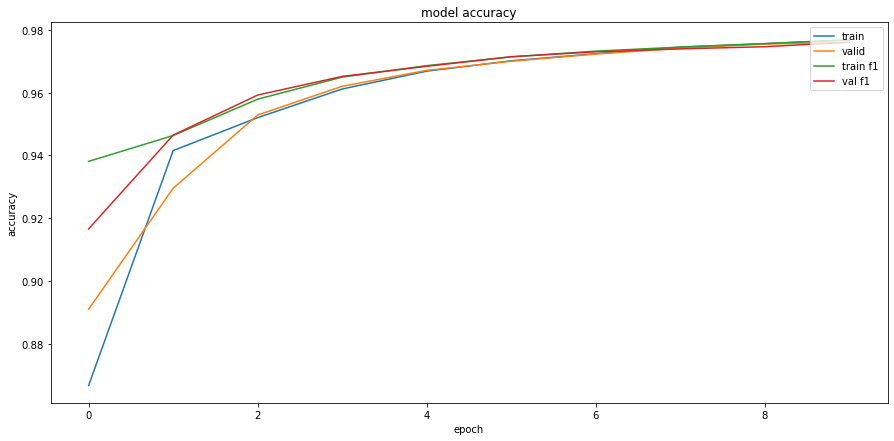

In [55]:
# summarize history for accuracy
plt.figure(figsize=(15, 7))
plt.plot(glove_lstm_base_model_history.history["get_f1"])
plt.plot(glove_lstm_base_model_history.history["accuracy"])
plt.plot(glove_lstm_base_model_history.history["val_get_f1"])
plt.plot(glove_lstm_base_model_history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "valid", "train f1", "val f1"], loc="upper right")
plt.show()

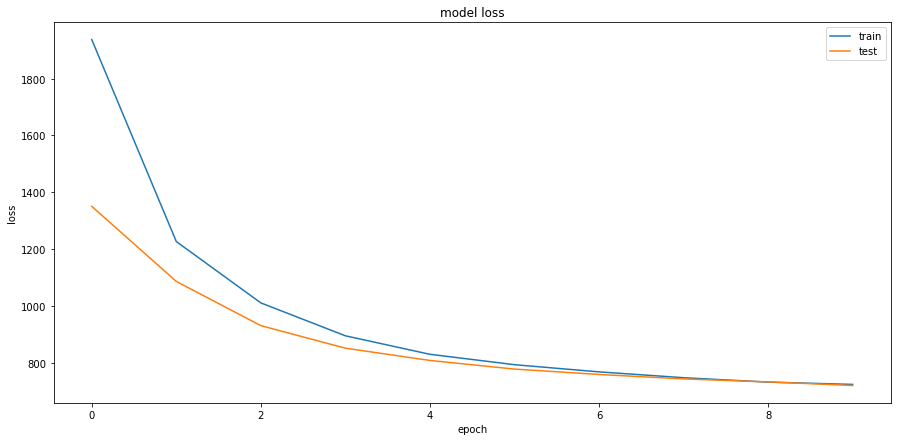

In [56]:
# summarize history for loss
plt.figure(figsize=(15, 7))
plt.plot(glove_lstm_base_model_history.history["loss"])
plt.plot(glove_lstm_base_model_history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [57]:
# Evaluate on test data
glove_lstm_base_model.evaluate(x_test_glove, y_test_glove, batch_size=batch_size)

39/39 [==============================] - 1s 22ms/step - loss: 719.4454 - get_f1: 0.9771 - accuracy: 0.9762


[719.4454345703125, 0.9770855903625488, 0.9761977195739746]

In [58]:
# Let's use test data for prediction
def prediction(model_obj, x):
    x = np.expand_dims(x, 0)
    result = model_obj.predict(x).argmax(-1)[0]

    return [id2cat[i] for i in result]

index = 155
result = prediction(glove_lstm_base_model, x_test_glove[index])

for i,j in zip(x_test[index], result):
    print(i.ljust(15), j)

who             o
starred         o
in              o
who             o
framed          i-title
roger           b-title
rabbit          i-title


### BiLSTM with Fasttext

#### Prepare input data

In [59]:
def fasttext_generator(fasttext_obj, cat2id, x, y, maxlen, categories):
    x_vector, y_vector = [], []
    
    x = keras.preprocessing.sequence.pad_sequences(sequences=x, maxlen=maxlen, padding="post", truncating="post", value="pad", dtype=object)
    y = keras.preprocessing.sequence.pad_sequences(sequences=y, maxlen=maxlen, padding="post", truncating="post", value="pad", dtype=object)
    
    for X, Y in zip(x, y):
        tmp_x = []
        tmp_y = []
        for word, label in zip(X, Y):
            tmp_x.append(fasttext_obj.get_word_vector(word))
            tmp_y.append(keras.utils.to_categorical(cat2id.get(label), len(categories)))

        x_vector.append(tmp_x)
        y_vector.append(tmp_y)

    return np.asarray(x_vector), np.asarray(y_vector)

In [60]:
x_trn_fasttext, y_trn_fasttext = fasttext_generator(fasttext_model, cat2id, x_trn, y_trn, maxlen, categories)
x_val_fasttext, y_val_fasttext = fasttext_generator(fasttext_model, cat2id, x_val, y_val, maxlen, categories)
x_test_fasttext, y_test_fasttext = fasttext_generator(fasttext_model, cat2id, x_test, y_test, maxlen, categories)

#### Neural network

In [61]:
def fasttext_lstm_base_model(categories, maxlen):
    
    input_layer = keras.Input(shape=(maxlen, 100))
    bi_lstm_layer = keras.layers.Bidirectional(keras.layers.LSTM(maxlen, return_sequences=True, recurrent_dropout=0.5))(input_layer)
    dense_layer = keras.layers.Dense(len(categories), activation="softmax")(bi_lstm_layer)
    
    model = keras.Model(input_layer, dense_layer)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02, 
                                                                                                       reduction=tf.keras.losses.Reduction.SUM), 
                  metrics=[get_f1, "accuracy"])
    
    return model

In [62]:
fasttext_lstm_base_model = fasttext_lstm_base_model(categories, maxlen)
fasttext_lstm_base_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 47, 100)]         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 47, 94)            55648     
_________________________________________________________________
dense_1 (Dense)              (None, 47, 26)            2470      
Total params: 58,118
Trainable params: 58,118
Non-trainable params: 0
_________________________________________________________________


In [63]:
checkpoints = keras.callbacks.ModelCheckpoint("best_fasttext_model.hdf5", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

batch_size = 64
epochs = 10
verbose = 1
training_records = x_trn_fasttext.shape[0]

fasttext_lstm_base_model_history = fasttext_lstm_base_model.fit(x_trn_fasttext, y_trn_fasttext, batch_size=batch_size, epochs=epochs, 
                                                            verbose=verbose, callbacks=[checkpoints], 
                                                            validation_data=(x_val_fasttext, y_val_fasttext), 
                                                            steps_per_epoch=training_records//batch_size)

Epoch 1/10
122/122 [==============================] - 43s 326ms/step - loss: 4039.8128 - get_f1: 0.5788 - accuracy: 0.7464 - val_loss: 1548.1285 - val_get_f1: 0.9239 - val_accuracy: 0.9146

Epoch 00001: val_accuracy improved from -inf to 0.91464, saving model to best_fasttext_model.hdf5
Epoch 2/10
122/122 [==============================] - 38s 313ms/step - loss: 1522.4914 - get_f1: 0.9239 - accuracy: 0.9138 - val_loss: 1408.7532 - val_get_f1: 0.9302 - val_accuracy: 0.9157

Epoch 00002: val_accuracy improved from 0.91464 to 0.91567, saving model to best_fasttext_model.hdf5
Epoch 3/10
122/122 [==============================] - 40s 327ms/step - loss: 1375.8710 - get_f1: 0.9320 - accuracy: 0.9176 - val_loss: 1253.8730 - val_get_f1: 0.9384 - val_accuracy: 0.9242

Epoch 00003: val_accuracy improved from 0.91567 to 0.92417, saving model to best_fasttext_model.hdf5
Epoch 4/10
122/122 [==============================] - 38s 312ms/step - loss: 1238.2510 - get_f1: 0.9383 - accuracy: 0.9268 - val_l

In [64]:
# list all data in history
print(fasttext_lstm_base_model_history.history.keys())

dict_keys(['loss', 'get_f1', 'accuracy', 'val_loss', 'val_get_f1', 'val_accuracy'])


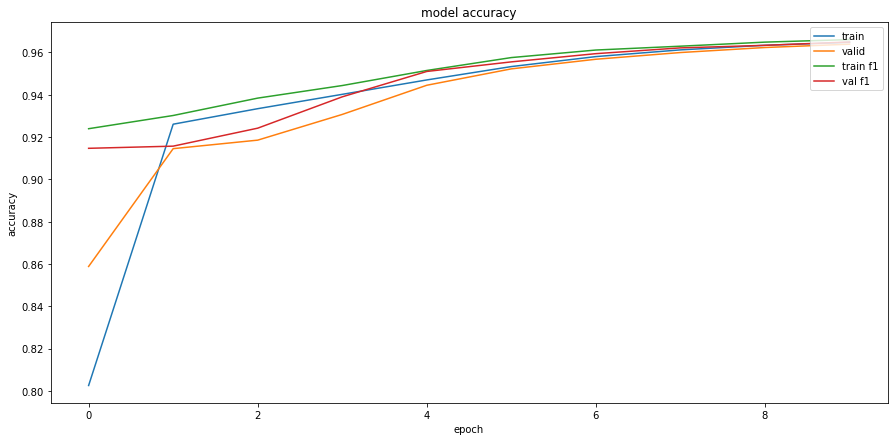

In [65]:
# summarize history for accuracy
plt.figure(figsize=(15, 7))
plt.plot(fasttext_lstm_base_model_history.history["get_f1"])
plt.plot(fasttext_lstm_base_model_history.history["accuracy"])
plt.plot(fasttext_lstm_base_model_history.history["val_get_f1"])
plt.plot(fasttext_lstm_base_model_history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "valid", "train f1", "val f1"], loc="upper right")
plt.show()

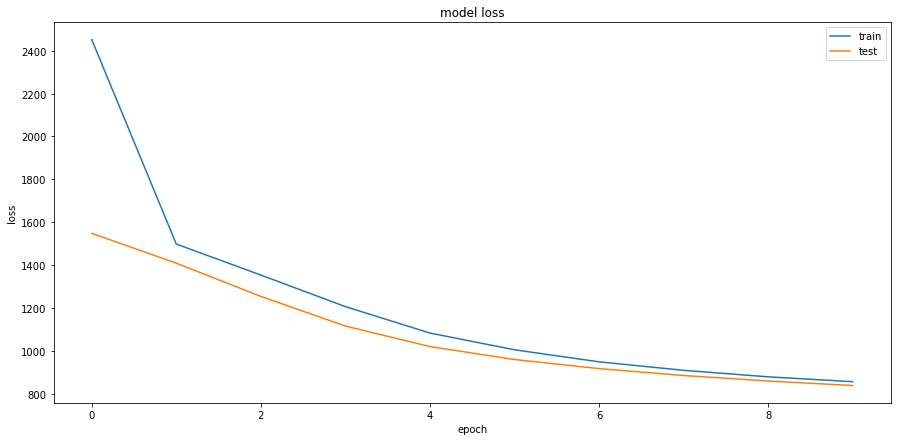

In [66]:
# summarize history for loss
plt.figure(figsize=(15, 7))
plt.plot(fasttext_lstm_base_model_history.history["loss"])
plt.plot(fasttext_lstm_base_model_history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [67]:
# Evaluate on test data
fasttext_lstm_base_model.evaluate(x_test_fasttext, y_test_fasttext, batch_size=batch_size)

39/39 [==============================] - 1s 21ms/step - loss: 835.4920 - get_f1: 0.9659 - accuracy: 0.9652


[835.4920043945312, 0.9658575057983398, 0.965241551399231]

In [68]:
# Let's use test data for prediction
def prediction(model_obj, x):
    x = np.expand_dims(x, 0)
    result = model_obj.predict(x).argmax(-1)[0]

    return [id2cat[i] for i in result]

index = 155
result = prediction(fasttext_lstm_base_model, x_test_fasttext[index])

for i, j, k in zip(x_test[index], y_test[index], result):
    print(i.ljust(15), j.ljust(15), k)

who             o               o
starred         o               o
in              o               o
who             b-title         o
framed          i-title         b-title
roger           i-title         i-title
rabbit          i-title         i-title


### LSTM with Glove - Multihead inputs (raw text and pos text)

#### Prepare input data

In [69]:
pos_tags = ["$", "''", "(", ")", ",", "--", ".", ":", "CC", "CD", "DT", "EX", "FW", "IN", "JJ", "JJR", "JJS", "LS", "MD", "NN", "NNP", "NNPS", "NNS", 
            "PDT", "POS", "PRP", "PRP$", "RB", "RBR", "RBS", "RP", "SYM", "TO", "UH", "VB", "VBD", "VBG", "VBN", "VBP", "VBZ", "WDT", "WP", "WP$", "WRB"]
pos_tags.append("PAD")

# PosTags to id mapping and vice versa
pos2id = {k.lower():i for i, k in enumerate(sorted(pos_tags))}
id2pos = {i:k.lower() for i, k in enumerate(sorted(pos_tags))}

print(f"pos2id: {pos2id}\n")
print(f"id2pos: {id2pos}")

pos2id: {'$': 0, "''": 1, '(': 2, ')': 3, ',': 4, '--': 5, '.': 6, ':': 7, 'cc': 8, 'cd': 9, 'dt': 10, 'ex': 11, 'fw': 12, 'in': 13, 'jj': 14, 'jjr': 15, 'jjs': 16, 'ls': 17, 'md': 18, 'nn': 19, 'nnp': 20, 'nnps': 21, 'nns': 22, 'pad': 23, 'pdt': 24, 'pos': 25, 'prp': 26, 'prp$': 27, 'rb': 28, 'rbr': 29, 'rbs': 30, 'rp': 31, 'sym': 32, 'to': 33, 'uh': 34, 'vb': 35, 'vbd': 36, 'vbg': 37, 'vbn': 38, 'vbp': 39, 'vbz': 40, 'wdt': 41, 'wp': 42, 'wp$': 43, 'wrb': 44}

id2pos: {0: '$', 1: "''", 2: '(', 3: ')', 4: ',', 5: '--', 6: '.', 7: ':', 8: 'cc', 9: 'cd', 10: 'dt', 11: 'ex', 12: 'fw', 13: 'in', 14: 'jj', 15: 'jjr', 16: 'jjs', 17: 'ls', 18: 'md', 19: 'nn', 20: 'nnp', 21: 'nnps', 22: 'nns', 23: 'pad', 24: 'pdt', 25: 'pos', 26: 'prp', 27: 'prp$', 28: 'rb', 29: 'rbr', 30: 'rbs', 31: 'rp', 32: 'sym', 33: 'to', 34: 'uh', 35: 'vb', 36: 'vbd', 37: 'vbg', 38: 'vbn', 39: 'vbp', 40: 'vbz', 41: 'wdt', 42: 'wp', 43: 'wp$', 44: 'wrb'}


In [70]:
def multihead_glove_generator(word2id, pos2id, cat2id, x, y, maxlen, categories):
    x_vector, y_vector, x_pos_vector = [], [], []
    
    x_pos = []
    for temp_x in x:
        x_pos.append([i[1].lower() for i in nltk.pos_tag(temp_x)])

    x = keras.preprocessing.sequence.pad_sequences(sequences=x, maxlen=maxlen, padding="post", truncating="post", value="pad", dtype=object)
    y = keras.preprocessing.sequence.pad_sequences(sequences=y, maxlen=maxlen, padding="post", truncating="post", value="pad", dtype=object)
    x_pos = keras.preprocessing.sequence.pad_sequences(sequences=x_pos, maxlen=maxlen, padding="post", truncating="post", value="pad", dtype=object)
    
    for X, Y, X_POS in zip(x, y, x_pos):
        tmp_x = []
        tmp_y = []
        tmp_x_pos = []
        for word, label, pos in zip(X, Y, X_POS):
            tmp_x.append(word2id.get(word, word2id.get("unk")))
            tmp_y.append(keras.utils.to_categorical(cat2id.get(label), len(categories)))
            tmp_x_pos.append(int(pos2id.get(pos)))

        x_vector.append(tmp_x)
        y_vector.append(tmp_y)
        x_pos_vector.append(tmp_x_pos)

    return np.asarray(x_vector), np.asarray(y_vector), np.asarray(x_pos_vector)

In [71]:
x_trn_glove, y_trn_glove, x_pos_trn_glove = multihead_glove_generator(glove_word2id, pos2id, cat2id, x_trn, y_trn, maxlen, categories)
x_val_glove, y_val_glove, x_pos_val_glove = multihead_glove_generator(glove_word2id, pos2id, cat2id, x_val, y_val, maxlen, categories)
x_test_glove, y_test_glove, x_pos_test_glove = multihead_glove_generator(glove_word2id, pos2id, cat2id, x_test, y_test, maxlen, categories)

#### Neural network

In [72]:
def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1_val

In [73]:
def lstm_base_model(matrix, categories, maxlen):
    
    word_layer = keras.Input(shape=(maxlen,), name="word")
    pos_layer = keras.Input(shape=(maxlen,), name="pos")
    word_embedding_layer = keras.layers.Embedding(400000, 100, weights=[matrix], input_length=maxlen, trainable=False)(word_layer)
    pos_embedding_layer = keras.layers.Embedding(len(pos_tags), 100, input_length=maxlen)(pos_layer)
    word_bi_lstm_layer = keras.layers.Bidirectional(keras.layers.LSTM(maxlen, return_sequences=True, recurrent_dropout=0.5))(word_embedding_layer)
    pos_bi_lstm_layer = keras.layers.Bidirectional(keras.layers.LSTM(maxlen, return_sequences=True, recurrent_dropout=0.5))(pos_embedding_layer)
    concate_layer = keras.layers.concatenate([word_bi_lstm_layer, pos_bi_lstm_layer])
    dense_layer = keras.layers.Dense(len(categories), activation="softmax")(concate_layer)
    
    model = keras.Model([word_layer, pos_layer], dense_layer)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02, 
                                                                                                       reduction=tf.keras.losses.Reduction.SUM), 
                  metrics=[get_f1, "accuracy"])
    
    return model

In [74]:
multihead_glove_lstm_base_model = lstm_base_model(glove_matrix, categories, maxlen)
multihead_glove_lstm_base_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
word (InputLayer)               [(None, 47)]         0                                            
__________________________________________________________________________________________________
pos (InputLayer)                [(None, 47)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 47, 100)      40000000    word[0][0]                       
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 47, 100)      4500        pos[0][0]                        
____________________________________________________________________________________________

In [75]:
checkpoints = keras.callbacks.ModelCheckpoint("best_multihead_glove_model.hdf5", monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")

batch_size = 64
epochs = 10
verbose = 1
training_records = x_trn_glove.shape[0]

multihead_glove_lstm_base_model_history = multihead_glove_lstm_base_model.fit([x_trn_glove, x_pos_trn_glove], y_trn_glove, 
                                                            batch_size=batch_size, epochs=epochs, verbose=verbose, callbacks=[checkpoints],
                                                            validation_data=([x_val_glove, x_pos_val_glove], y_val_glove), 
                                                            steps_per_epoch=training_records//batch_size)

Epoch 1/10
122/122 [==============================] - 81s 611ms/step - loss: 3202.9601 - get_f1: 0.6763 - accuracy: 0.8003 - val_loss: 1339.2731 - val_get_f1: 0.9380 - val_accuracy: 0.9166

Epoch 00001: val_accuracy improved from -inf to 0.91659, saving model to best_multihead_glove_model.hdf5
Epoch 2/10
122/122 [==============================] - 74s 610ms/step - loss: 1240.7906 - get_f1: 0.9423 - accuracy: 0.9259 - val_loss: 1023.0857 - val_get_f1: 0.9504 - val_accuracy: 0.9503

Epoch 00002: val_accuracy improved from 0.91659 to 0.95031, saving model to best_multihead_glove_model.hdf5
Epoch 3/10
122/122 [==============================] - 74s 609ms/step - loss: 978.8878 - get_f1: 0.9535 - accuracy: 0.9534 - val_loss: 885.2250 - val_get_f1: 0.9618 - val_accuracy: 0.9615

Epoch 00003: val_accuracy improved from 0.95031 to 0.96147, saving model to best_multihead_glove_model.hdf5
Epoch 4/10
122/122 [==============================] - 75s 615ms/step - loss: 864.0404 - get_f1: 0.9625 - accura

In [76]:
# list all data in history
print(multihead_glove_lstm_base_model_history.history.keys())

dict_keys(['loss', 'get_f1', 'accuracy', 'val_loss', 'val_get_f1', 'val_accuracy'])


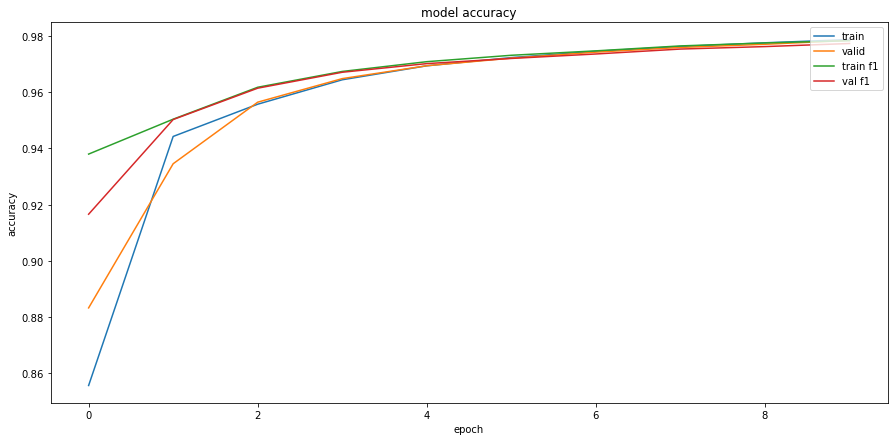

In [77]:
# summarize history for accuracy
plt.figure(figsize=(15, 7))
plt.plot(multihead_glove_lstm_base_model_history.history["get_f1"])
plt.plot(multihead_glove_lstm_base_model_history.history["accuracy"])
plt.plot(multihead_glove_lstm_base_model_history.history["val_get_f1"])
plt.plot(multihead_glove_lstm_base_model_history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "valid", "train f1", "val f1"], loc="upper right")
plt.show()

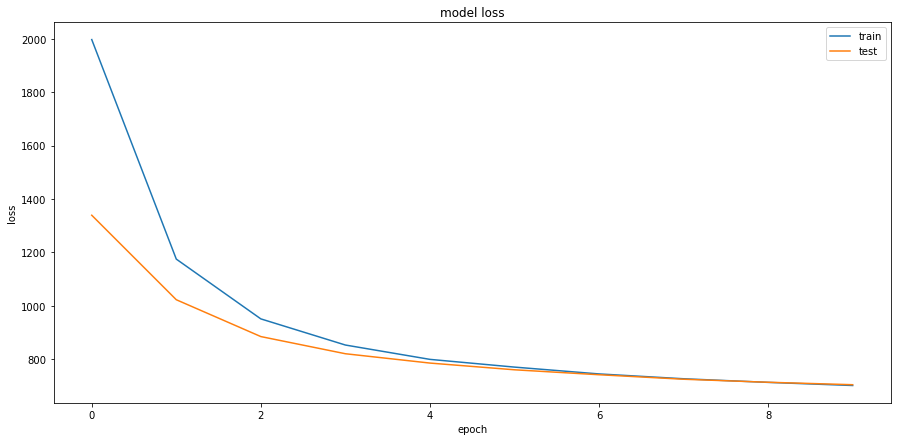

In [78]:
# summarize history for loss
plt.figure(figsize=(15, 7))
plt.plot(multihead_glove_lstm_base_model_history.history["loss"])
plt.plot(multihead_glove_lstm_base_model_history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper right")
plt.show()

In [79]:
# Evaluate on test data
multihead_glove_lstm_base_model.evaluate([x_test_glove, x_pos_test_glove], y_test_glove, batch_size=batch_size)

39/39 [==============================] - 3s 73ms/step - loss: 705.6097 - get_f1: 0.9783 - accuracy: 0.9777


[705.6096801757812, 0.9783375859260559, 0.9777131080627441]

In [80]:
# Let's use test data for prediction
def prediction(model_obj, x, x_pos):
    x = np.expand_dims(x, 0)
    x_pos = np.expand_dims(x_pos, 0)
    result = model_obj.predict([x, x_pos]).argmax(-1)[0]

    return [id2cat[i] for i in result]

index = 155
result = prediction(multihead_glove_lstm_base_model, x_test_glove[index], x_pos_test_glove[index])

for i,j in zip(x_test[index], result):
    print(i.ljust(15), j)

who             o
starred         o
in              o
who             o
framed          b-title
roger           b-title
rabbit          i-title


### List of LSTM based algorithms
Considering glove as embedding layer but same will be worked out fasttext too just making small tweak in embedding layer

### CNN + LSTM

In [81]:
# In this model we are using Convolutional 1D layer in which conv filters will be rotated only in direction
def cnn_lstm_model(matrix, categories, maxlen):
    
    input_layer = keras.Input(shape=(maxlen,))
    embedding_layer = keras.layers.Embedding(400000, 100, weights=[matrix], input_length=maxlen, trainable=False)(input_layer)
    cnn_layer = keras.layers.Conv1D(300, 3, activation="relu", padding="same")(embedding_layer)
    bi_lstm_layer = keras.layers.Bidirectional(keras.layers.LSTM(maxlen, return_sequences=True, recurrent_dropout=0.5))(cnn_layer)
    dense_layer = keras.layers.Dense(len(categories), activation="softmax")(bi_lstm_layer)
    
    model = keras.Model(input_layer, dense_layer)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02, 
                                                                                                       reduction=tf.keras.losses.Reduction.SUM), 
                  metrics=[get_f1, "accuracy"])
    
    return model

cnn_lstm_model = cnn_lstm_model(glove_matrix, categories, maxlen)
cnn_lstm_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 47)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 47, 100)           40000000  
_________________________________________________________________
conv1d (Conv1D)              (None, 47, 300)           90300     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 47, 94)            130848    
_________________________________________________________________
dense_3 (Dense)              (None, 47, 26)            2470      
Total params: 40,223,618
Trainable params: 223,618
Non-trainable params: 40,000,000
_________________________________________________________________


### BERT

#### Prepare input data & everything else 

In [82]:
import torch
from torch import nn
from torch import optim
from torch import functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import transformers
from transformers import BertTokenizer, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup

transformers.__version__

'4.2.2'

In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [84]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-cased", do_lower_case=True)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [85]:
def bert_generator(tokenizer, cat2id, x, y, maxlen, categories):
    x_vector, y_vector, x_attention_masks = [], [], []
    
    for sentence in tqdm(x):
        tokenized_sentence = tokenizer.encode(sentence, add_special_tokens=True, max_length=maxlen)
        x_vector.append(tokenized_sentence)
        
    x_vector = keras.preprocessing.sequence.pad_sequences(sequences=x_vector, maxlen=maxlen, padding="post", truncating="post", value=0, dtype="long")
    
    for sentence in x_vector:
        att_mask = [int(token_id > 0) for token_id in sentence]
        x_attention_masks.append(att_mask)
    
    y = keras.preprocessing.sequence.pad_sequences(sequences=y, maxlen=maxlen, padding="post", truncating="post", value="pad", dtype=object)
    
    for Y in y:
        tmp_y = []
        for label in Y:
            tmp_y.append(cat2id.get(label))

        y_vector.append(tmp_y)

    return np.asarray(x_vector), np.asarray(x_attention_masks), np.asarray(y_vector)

In [86]:
x_trn_bert, x_attention_trn_bert, y_trn_bert = bert_generator(bert_tokenizer, cat2id, x_trn, y_trn, maxlen, categories)
x_val_bert, x_attention_val_bert, y_val_bert = bert_generator(bert_tokenizer, cat2id, x_val, y_val, maxlen, categories)
x_test_bert, x_attention_test_bert, y_test_bert = bert_generator(bert_tokenizer, cat2id, x_test, y_test, maxlen, categories)

100%|██████████| 2443/2443 [00:00<00:00, 16099.39it/s]


In [87]:
# convert to torch tenors
x_trn_bert = torch.tensor(x_trn_bert)
x_val_bert = torch.tensor(x_val_bert)
x_test_bert = torch.tensor(x_test_bert)
x_attention_trn_bert = torch.tensor(x_attention_trn_bert)
x_attention_val_bert = torch.tensor(x_attention_val_bert)
x_attention_test_bert = torch.tensor(x_attention_test_bert)
y_trn_bert = torch.tensor(y_trn_bert)
y_val_bert = torch.tensor(y_val_bert)
y_test_bert = torch.tensor(y_test_bert)

In [88]:
bert_batch_size = 32
bert_trn_dataset = DataLoader(TensorDataset(x_trn_bert, x_attention_trn_bert, y_trn_bert), batch_size=bert_batch_size, shuffle=True)
bert_val_dataset = DataLoader(TensorDataset(x_val_bert, x_attention_val_bert, y_val_bert), batch_size=bert_batch_size, shuffle=False)
bert_test_dataset = DataLoader(TensorDataset(x_test_bert, x_attention_test_bert, y_test_bert), batch_size=bert_batch_size, shuffle=False)

#### Neural network

In [89]:
bert_model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(categories), output_attentions = False, 
                                                   output_hidden_states = False)
bert_model.cuda();

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [90]:
optimizer = optim.AdamW(bert_model.parameters(), lr=3e-5, eps=1e-8)

#schduler to reduce learning rate linearly throughout the epochs
epochs = 5
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(bert_trn_dataset) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [91]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [92]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    bert_model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(bert_trn_dataset):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        bert_model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = bert_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=bert_model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(bert_trn_dataset)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    # Put the model into evaluation mode
    bert_model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in bert_val_dataset:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = bert_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [[id2cat[p_i] for p_i, l_i in zip(p, l) if id2cat[l_i] != "PAD"] for p, l in zip(predictions, true_labels)]
    valid_tags = [[id2cat[l_i] for l_i in l if id2cat[l_i] != "PAD"]for l in true_labels]
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    print()

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Average train loss: 0.5278946014083161
Validation loss: 0.25886256115571143
Validation Accuracy: 0.366663806909174


/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: o seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: b-title seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: i-title seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: pad seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: b-plot seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: 

Validation F1-Score: 0.22450941129355229

Average train loss: 0.2120168062193053
Validation loss: 0.2248410511641733
Validation Accuracy: 0.37906085563944175


Epoch:  40%|████      | 2/5 [01:40<02:30, 50.32s/it]

Validation F1-Score: 0.22729162953721857

Average train loss: 0.16431374131720894
Validation loss: 0.21788503698283626
Validation Accuracy: 0.3645583104552734


Epoch:  60%|██████    | 3/5 [02:30<01:40, 50.24s/it]

Validation F1-Score: 0.23050820392031615

Average train loss: 0.13363147279133603
Validation loss: 0.2184179168675215
Validation Accuracy: 0.36168425417524586


Epoch:  80%|████████  | 4/5 [03:21<00:50, 50.26s/it]

Validation F1-Score: 0.23030134923622528

Average train loss: 0.1136078654579362
Validation loss: 0.22028219471535376
Validation Accuracy: 0.36396848547243205


Epoch: 100%|██████████| 5/5 [04:11<00:00, 50.22s/it]

Validation F1-Score: 0.2303729243451036



In [93]:
bert_model.save_pretrained("crisil_ner")

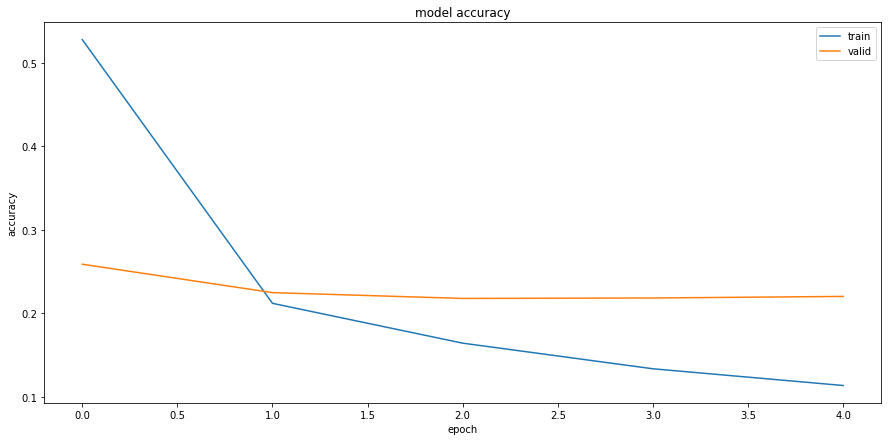

In [94]:
# summarize history for loss
plt.figure(figsize=(15, 7))
plt.plot(loss_values, label="training loss")
plt.plot(validation_loss_values, label="validation loss")
plt.title("model accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

In [95]:
# Let's use test data for prediction
def prediction(model_obj, x, x_attention):
    with torch.no_grad():
        result = bert_model(x.to("cuda"), x_attention.to("cuda"))

    return [id2cat.get(word.item()) for word in torch.argmax(torch.softmax(result.logits, axis=-1), axis=-1)[0]]

index = 155
result = prediction(bert_model, x_test_bert[index:index+1], x_attention_test_bert[index:index+1])

for i, j, k in zip(x_test[index], y_test[index], result):
    print(i.ljust(15), j.ljust(15), k)

who             o               o
starred         o               o
in              o               o
who             b-title         o
framed          i-title         o
roger           i-title         b-character
rabbit          i-title         i-title
